### CS 369 2019 


Student: Jack Goodson

UPI: JGOO420


## Assignment 3 : Simulations (13 + 2 points)


In this assignment you will write code to 
- simulate random coalescent trees, 
- simulate DNA sequences on those trees, 
- reconstruct trees from the simulated sequences,
- implement the Fitch algorithm.

13 points for five questions, and the extra 2 points for well documented source code. 7.5% of final grade.

Due: Friday 24th May 23:59


### Instructions

Please update your name and UPI above.  

Write your submission in a Jupyter notebook and write any code in Python 3. You should submit the .ipynb file. The primary document the markers will look at is the .ipynb file.

In your report, include explanations of what you are doing and comments in the code. Where you are making mathematical derivations, show your working.


In [3]:
# import packages

from platform import python_version
print("python", python_version())

import numpy as np
print("numpy", np.version.version)

import matplotlib 
print("matplotlib", matplotlib.__version__)

import scipy 
print("scipy", scipy.__version__)

import matplotlib.pyplot as plt

python 3.7.1
numpy 1.15.4
matplotlib 3.0.2
scipy 1.1.0


The Python classes to implement a UPGMA tree are available in _UPGMA.py_. Please make sure you load it successfully before you start coding. 

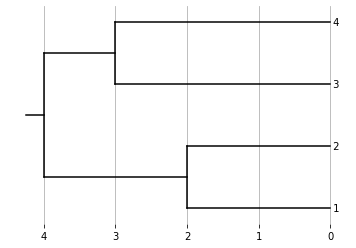

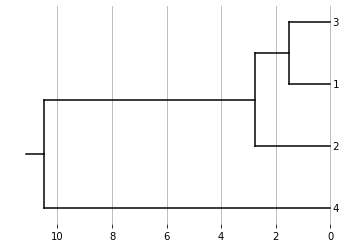

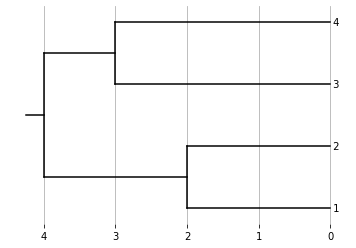

<Figure size 432x288 with 0 Axes>

In [3]:
%matplotlib inline
tree = compute_upgma_tree([[0, 4, 8, 8],
                           [4, 0, 8, 8], 
                           [8, 8, 0, 6], 
                           [8, 8, 6, 0]])
plot_tree(tree)
# Note: the given Python classes are imported successfully only when the plotted tree is shown below, 
# otherwise please run this cell again.   
%run UPGMA.py

## Question 1: Kingman coalescent model

### i. Implement Kingman coalescent model (1 points)

Write a method that simulates trees according to the Kingman coalescent model (described below) which takes as input the number of leaves, $n$, and the effective population size, $N_e$. Use the provided Python classes to represent a tree (available on Canvas).

The Kingman coalescent model is a lineage death process backwards in time that
provides a simple algorithm for simulating a gene tree of $n$ chromosomes from a
larger population of $N_e$ chromosomes. From each leaf, start a lineage going back in
time. Each pair of lineages coalesces at rate $1/N_e$. When there are $k$ lineages, the
total rate of coalescence in the tree is $􏰃{k \choose 2}􏰄/N_e$. Thus, we can generate a coalescent
tree with $n$ leaves as follows:

<!---<img src="coalescent.png",width=700,height=500>--->

<!--- code block ``` cannot work with math --->

Set $k = n, t = 0$.

Make $n$ leaf nodes with time $t = 0$ and labeled from 1 to $n$. This is the set of available nodes.

While $k > 1$, iterate:

> Generate a time $t_k$ and set $t = t + t_k$.
where $$t_k ∼ Exp􏰇􏰃({k \choose 2}􏰄/N_e)$$

> Make a new node, $m$, with height $t$ and choose two distinct nodes, $i$ and $j$,
         uniformly at random from the set of available nodes. Make $i$ and $j$ the
         child nodes of $m$.       

> Add $m$ to the set of available nodes and remove $i$ and $j$ from this set.

> Set $k = k − 1$.


If the above algorithm isn't displayed properly, you can see it from the attached file "coalescent.png".


In [215]:
import scipy.stats

np.random.seed(1234)

def coalescent(n,Ne):
    node_set = [] 
    for i in range(n): # Generate leaf nodes at height 0 with labels 
        j = Node(i)
        j.set_label(str(i + 1))
        j.set_height(0)
        node_set.append(j) # add node labelled of height 0 to set of availible nodes
    k = n
    t = 0
    while k > 1:
        k_choose_2 = np.math.factorial(k) / (2 * (np.math.factorial(k-2))) # calculate k choose 2
        tk = np.random.exponential(1/(k_choose_2/Ne)) # random choice from exp dist with 1/k choose 2 parameter
        t = t + tk
        m = Node()
        m.set_height(t)  # set current height to t for new node m
        ij = np.random.choice(len(node_set), 2, replace = False) # choose 2 numbers to index random node choice
        i_node = node_set[ij[0]-1] # choose node from node set
        del node_set[ij[0]-1] # delete node from node set
        j_node = node_set[ij[1]-1] # second node choice
        del node_set[ij[1]-1] # second node choice deletion
        m.add_child(i_node)
        m.add_child(j_node)
        node_set.append(m) # add node m with two child nodes attached
        k -=1
    tree = Tree()
    tree.set_root(node_set[0]) # create a tree with top node from our node set as the root
    return tree

### ii. Simulate trees (1 points)

Given $n = 10$ and $N_e = 200$, the theoretical mean height of the simulated trees should be: 
$$ E( height(n, N_e) ) = 2 N_e (1 - \frac{1}{n}) = 2 \times 200 \times 0.9 = 360$$

1. To check the correctness of your implementation, simulate 1,000 trees and check that the mean height of the trees (that is, the time of the root node) agrees with the theoretical mean.

2. What happens if you simulate 10,000 trees?

3. Use the provided plot tree method to include a picture of a simulated tree using the given $n$ and $N_e$ in your report.


Average height: 359


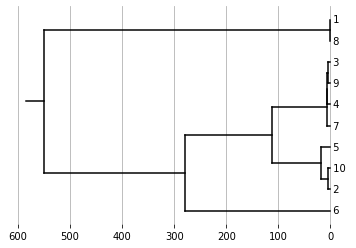

In [284]:
mean = []
n = 10
Ne = 200
for i in range(10000):
    t = coalescent(n, Ne)
    mean.append(t.get_root().get_height()) # get height of root node and append to list
print("Average height:",int(np.round(np.average(mean)))) # average and round all samples
plot_tree(t)

## Question 2: Jukes-Cantor substitution down a tree

### i. Write a method (1 points)

to simulate sequences down a simulated tree according to the Jukes-Cantor substitution model. Your method should take a tree with $n$ leaves, sequence length $L$, and a mutation rate $\mu$. It should return the tree with sequences stored at the nodes using the method `set_sequence(sequence)`.

Your method should generate a uniform random sequence of length $L$ at the root node and recursively mutate it down the branches of the tree, using the node heights to calculate branch length. Pseudocode methods for random sequence generation and mutation down a lineage are provided at the end of this problem.

You may reuse your code from Assignment 2 + modifications.


__Pseudocode of the methods__

The method randseq simulates a uniform random sequence. The method mutates a given sequence according to the Jukes-Cantor model of mutation over a given length.

```
randseq(L)
  for (i in 1 to L)
    seq[i] = choice([’A’,’C’,’G’,’T’], [0.25,0.25,0.25,0.25])
  return seq
```

The mutate method below allows “mutations” from a base to itself. The uncorrected mutation rate ($\mu$ rather than 3$\mu$) can therefore be used.

```
mutate(X,t,mu)
  L= X.length()
  # the number of mutations is Poisson with total rate L*mu*t
  numMutation = randpoiss(L*mu*t)
  # for each mutation, choose a site to mutate and mutate it
  for (i in 1 to numMutation)
    # choose a site
    site = ceiling(random()*L)
    # mutate that site
    X[site] =  choice([’A’,’C’,’G’,’T’], [0.25,0.25,0.25,0.25])
return X
```


In [285]:
def rand_seq(L):
    seq = []
    for i in range(L): # create sequence of length L
        seq.append(np.random.choice(["A", "C", "G", "T"])) # choose a random base for each point in a sequence
    return seq
        
def mutate(X, t, mu):
    L = len(X)
    numMut = np.random.poisson(L*mu*t) # calculate the number of mutations given sequence length, mu and time
    mX = X.copy()
    for k in range(numMut): # go through sequence and mutate for how many mutations we generated
        site = np.random.choice(L) # choose random site in the sequence to mutate
        mX[site] = np.random.choice(["A", "C", "G", "T"]) # change the site in the sequence to a random mutation
    return mX

def visit(node, mu):
    if not(node.is_root()): # if the node isn't the root give it a mutated sequence from it's parent
        seq = node.get_parent().get_sequence() # get parent sequence to mutate
        tdiff = node.get_parent().get_height() - node.get_height() # get height difference between node and parent 
        node.set_sequence(mutate(seq, tdiff, mu)) # set mutated parents sequence as nodes sequence
    
    for c in range(len(node.get_children())): # run the method for each child 
        visit(node.get_children()[c], mu)


def jc(t, L, mu):
    root = t.get_root()
    root.set_sequence(rand_seq(L)) # generate sequence for root of tree
    visit(root, mu) # call tree mutation/traversal method
    t = Tree(root)
    return t

### ii. Test your method (1 points)

Use the tree simulated in Question 1, and print all sequences of the tips labelled by the tip names.

In [286]:
jc(t, 10, 0.01)
for i in t.get_leaves(): # print leaves labels with sequences associated for tree
    print("Node with Label:",i.get_label(),"".join(i.get_sequence()))

Node with Label: 6 ATCGGTCTGA
Node with Label: 2 GGAGATCCAT
Node with Label: 10 GGAGATCCAT
Node with Label: 5 GCAGATGCCT
Node with Label: 7 TGCCAGCACT
Node with Label: 4 AGCCAGCACT
Node with Label: 9 TGCCAGCACA
Node with Label: 3 TGCCAGCACA
Node with Label: 8 TTCCTGAGTA
Node with Label: 1 TTCCTGAGTA


## Question 3: Building a distance matrix

### i. Write a method (1 points)

to calculate the Jukes-Cantor distance matrix, $d$, from a set of sequences, where $d_{ij}$ is the distance between the $i$th and the $j$th sequences. Recall that the Jukes-Cantor distance for sequences $x$ and $y$ is defined by

$$ d_{xy} = −\frac{3}{4}log(1 − \frac{4f_{xy}}{3}) $$  

<!--- <img src="JCdist.png",width=300,height=200> --->

  where $f_{xy}$ is the fraction of differing sites between $x$ and $y$. Since we will be dealing with short sequences, use the following definition of $f_{xy}$ so that the distances are well-defined:

􏰉$$ f_{xy} = min ( \frac{D_{xy}}{L} , 0.75 − \frac{1}{L}) $$

<!--- <img src="JCfrac.png",width=300,height=200> --->

  where $D_{xy}$ is the number of differing sites between $x$ and $y$, and $L$ is the length of $x$.


If the above equations aren't displayed properly, you can see them from the attached files "JCdist.png" and "JCfrac.png".

In [287]:
def dist_mat(seq_list):
    L = len(seq_list[0]) # generate length sequences given
    mat = np.zeros([len(seq_list), len(seq_list)], dtype = float) # generate matrix for length of sequence list
    for i in range(len(seq_list)): # add values to matrix row-wise 
        for j in range(len(seq_list)):
            x = seq_list[i] 
            y = seq_list[j]
            diff_sites = sum(1 for a, b in zip(x, y) if a != b) # count the number of differing sites given x and y
            mat[i][j] = -3/4 * np.log(1 - ((4*compute_f(diff_sites, L))/3)) # generate jukes cantor distance
    return mat

def compute_f(diff, L):
    return min((diff/L), 0.75-(1/L)) # generate fraction of differing sites

### ii. Test your method (1 points)

Include a simulated set of sequences of length $L = 20$ from the tree leaves and corresponding distance matrix in your report for a tree with $n = 10$, $Ne = 200$ and the mutation parameter $\mu = 0.03$.

In [288]:
jc(t, 20, 0.03) # modify tree with jc and mutate it
sequences = []
for i in t.get_leaves(): 
    sequences.append("".join(i.get_sequence())) # get sequences and append to list as joined strings
dist_mat(sequences) # pass our list of strings and generate distance matrix

array([[-0.        ,  2.03103765,  2.03103765,  2.03103765,  2.03103765,
         2.03103765,  2.03103765,  2.03103765,  2.03103765,  2.03103765],
       [ 2.03103765, -0.        ,  0.10732563,  0.68721805,  2.03103765,
         2.03103765,  2.03103765,  2.03103765,  2.03103765,  2.03103765],
       [ 2.03103765,  0.10732563, -0.        ,  0.68721805,  2.03103765,
         2.03103765,  2.03103765,  2.03103765,  2.03103765,  2.03103765],
       [ 2.03103765,  0.68721805,  0.68721805, -0.        ,  2.03103765,
         2.03103765,  2.03103765,  2.03103765,  2.03103765,  2.03103765],
       [ 2.03103765,  2.03103765,  2.03103765,  2.03103765, -0.        ,
         0.2326162 ,  0.10732563,  0.2326162 ,  2.03103765,  2.03103765],
       [ 2.03103765,  2.03103765,  2.03103765,  2.03103765,  0.2326162 ,
        -0.        ,  0.10732563,  0.2326162 ,  2.03103765,  2.03103765],
       [ 2.03103765,  2.03103765,  2.03103765,  2.03103765,  0.10732563,
         0.10732563, -0.        ,  0.10732563

## Question 4: Reconstruct tree using UPGMA

### i. Write a method (1 points)

Write a method 
- to simulate the set of sequences from the given tree leaves with a given length (e.g. $L = 50$) and the mutation parameter $\mu$. This tree will be simulated (e.g. with $n = 10$ and $N_e = 200$) using your code in Question 1. You can also use your code in Question 2 to simulate the set of sequences.  
- and then, for each simulated set of sequences from the leaves, calculate the distance matrix and print it out. This can use your code in Question 3. 
- for each distance matrix, reconstruct the tree using the provided `compute_upgma_tree()` method and plot the reconstructed tree using `plot_tree()`.

In a summary, your method should print a distance matrix and the reconstructed tree from this matrix, given an original tree, the sequence length, and $\mu$.   


In [289]:
def UPGMA(t, L, mu):  
    jc(t, L, mu) # mutate given tree with jukes-cantor method
    sequences = []
    leaves = t.get_leaves() # get leaves from given tree
    sort_leaves = []
    for q in range(len(leaves)): # sort nodes by labels so labels match in reconstructed tree
        for z in leaves:
            if int(z.get_label()) == q + 1:
                sort_leaves.append(z)
    for i in sort_leaves: # add leaf sequences to list as strings
        sequences.append("".join(i.get_sequence()))
    matrix = dist_mat(sequences) # generate distance matrix
    print(matrix)
    upgma_t = compute_upgma_tree(matrix) # reconstruct UPGMA tree
    plot_tree(upgma_t)

### ii. The "true" tree (1 points)

Now use the Question 1 code to simulate a coalescent tree with $n = 10$ and $N_e = 200$, which will be the original tree to compare with a plot of each reconstructed tree. Plot it below.


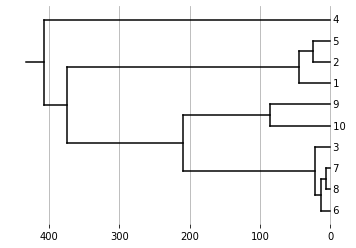

In [309]:
true_tree = coalescent(10, 200)
plot_tree(true_tree)

### iii. Test & report (1 points)

Test your method with the fixed $\mu = 0.03$ and with lengths $L = 50$, $L = 200$ and $L = 1000$ respectively.

Comment on the quality of the reconstructions and the effect that increasing the sequence length has on the accuracy of the reconstruction.

[[-0.          2.7182557   2.7182557   2.7182557   2.41415687  2.41415687
   2.7182557   2.7182557   2.7182557   2.7182557 ]
 [ 2.7182557  -0.          2.7182557   1.59019765  1.20707843  2.41415687
   2.03103765  1.77868347  2.7182557   2.7182557 ]
 [ 2.7182557   2.7182557  -0.          2.7182557   2.03103765  2.03103765
   1.02978685  1.20707843  2.7182557   2.7182557 ]
 [ 2.7182557   1.59019765  2.7182557  -0.          2.7182557   1.77868347
   2.03103765  2.03103765  2.7182557   2.7182557 ]
 [ 2.41415687  1.20707843  2.03103765  2.7182557  -0.          2.7182557
   2.7182557   2.7182557   2.7182557   2.41415687]
 [ 2.41415687  2.41415687  2.03103765  1.77868347  2.7182557  -0.
   0.82395922  0.88649542  1.77868347  2.7182557 ]
 [ 2.7182557   2.03103765  1.02978685  2.03103765  2.7182557   0.82395922
  -0.          0.28924686  2.7182557   2.7182557 ]
 [ 2.7182557   1.77868347  1.20707843  2.03103765  2.7182557   0.88649542
   0.28924686 -0.          2.7182557   2.7182557 ]
 [ 2.7182

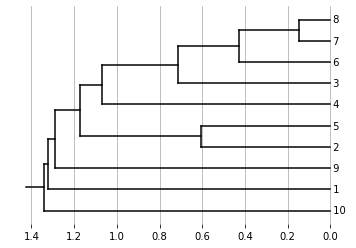

[[-0.          2.19839531  2.7182557   2.19839531  1.77868347  2.55089804
   3.75797647  3.75797647  2.7182557   3.75797647]
 [ 2.19839531 -0.          2.41415687  3.75797647  1.18248607  3.75797647
   3.75797647  3.75797647  3.23811609  2.93401725]
 [ 2.7182557   2.41415687 -0.          3.75797647  3.75797647  0.80910725
   1.01030524  0.97279742  3.75797647  2.93401725]
 [ 2.19839531  3.75797647  3.75797647 -0.          3.75797647  3.75797647
   3.23811609  3.75797647  2.7182557   2.11005804]
 [ 1.77868347  1.18248607  3.75797647  3.75797647 -0.          3.23811609
   3.75797647  3.75797647  3.75797647  2.7182557 ]
 [ 2.55089804  3.75797647  0.80910725  3.75797647  3.23811609 -0.
   0.49044485  0.56096656  3.75797647  3.75797647]
 [ 3.75797647  3.75797647  1.01030524  3.23811609  3.75797647  0.49044485
  -0.          0.32694324  3.75797647  3.75797647]
 [ 3.75797647  3.75797647  0.97279742  3.75797647  3.75797647  0.56096656
   0.32694324 -0.          3.75797647  3.75797647]
 [ 2.718

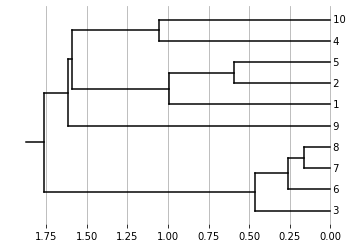

[[-0.          2.25686647  4.9650549   4.9650549   1.97331687  4.9650549
   3.10137492  3.92533413  3.50562229  3.40547375]
 [ 2.25686647 -0.          4.9650549   3.92533413  1.22223046  4.9650549
   4.9650549   3.16663345  2.88561336  4.9650549 ]
 [ 4.9650549   4.9650549  -0.          4.9650549   4.9650549   0.99885463
   1.0457449   1.07871724  4.9650549   4.9650549 ]
 [ 4.9650549   3.92533413  4.9650549  -0.          4.9650549   4.44519452
   3.40547375  2.58151453  4.9650549   3.16663345]
 [ 1.97331687  1.22223046  4.9650549   4.9650549  -0.          4.9650549
   4.9650549   4.9650549   3.40547375  4.9650549 ]
 [ 4.9650549   4.9650549   0.99885463  4.44519452  4.9650549  -0.
   0.61801159  0.64824824  4.9650549   4.9650549 ]
 [ 3.10137492  4.9650549   1.0457449   3.40547375  4.9650549   0.61801159
  -0.          0.28047483  4.9650549   3.6212353 ]
 [ 3.92533413  3.16663345  1.07871724  2.58151453  4.9650549   0.64824824
   0.28047483 -0.          4.9650549   2.93401725]
 [ 3.505622

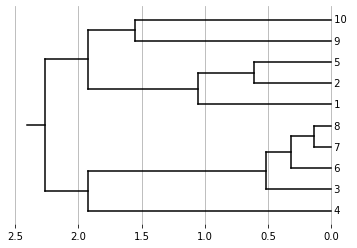

In [310]:
UPGMA(true_tree, 50, 0.03)
UPGMA(true_tree, 200, 0.03)
UPGMA(true_tree, 1000, 0.03)

The accuracy increases of the UPGMA tree reconstruction as sequence lengths get longer as there is less information loss of sites that get mutated multiple times on longer sequences compared to shorter ones.

## Question 5: Fitch's algorithm

### i. Simulation (1 points)

Write a method that simulates the set of sequences down a given (coalescent) tree according to the Jukes-Cantor substitution model, which takes as input a tree  (the tree class is provided by the Python file), the sequence length $L$ and $\mu$. You may reuse your code in Question 2. The method needs to return the tree with sequences stored at the nodes, and also the total number of mutations during the simulation.

Test your method using the coalescent tree that you produced in Question 4 ii and assigning $L = 100$ and $\mu = 0.05$. Then, plot the tree and report the total number of mutations.


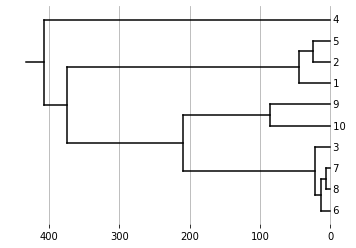

7782 mutations occuorred


In [311]:
def m_rand_seq(L):
    seq = []
    for i in range(L): # create sequence of length L
        seq.append(np.random.choice(["A", "C", "G", "T"]))
    return seq
        
def m_mutate(X, t, mu, tot_mut):
    L = len(X)
    numMut = np.random.poisson(L*mu*t) # calculate the number of mutations given sequence length, mu and time
    mX = X.copy()
    mut_count = 0
    for k in range(numMut): # go through sequence and mutate for how many mutations we generated
        site = np.random.choice(L) # choose random site in the sequence to mutate
        mX[site] = np.random.choice(["A", "C", "G", "T"]) # change the site in the sequence to a random mutation
        mut_count +=1 # count mutations in sequence
    tot_mut.append(mut_count) # append mutation for particular sequence to total count
    return mX

def m_visit(node, mu, tot_mut):
    if not(node.is_root()): # if node isn't the root give it a mutated sequence from it's parent node
        seq = node.get_parent().get_sequence()
        tdiff = node.get_parent().get_height() - node.get_height() # get height difference between parent and node
        node.set_sequence(m_mutate(seq, tdiff, mu, tot_mut)) # set mutated sequence as nodes sequence
    
    for c in range(len(node.get_children())): # run the method for each child 
        m_visit(node.get_children()[c], mu, tot_mut)
   
def jc_muts(t, L, mu):
    tot_mut = []
    root = t.get_root()
    root.set_sequence(m_rand_seq(L)) # generate and set sequence for root of tree
    m_visit(root, mu, tot_mut) # call tree mutation/traversal method
    t = Tree(root)
    tree_muts = np.sum(tot_mut) # sum total mutations 
    return t, tree_muts

true_tree_results = jc_muts(true_tree, 100, 0.05)

plot_tree(true_tree_results[0])
print(true_tree_results[1], "mutations occuorred")

### ii. Implement the Fitch algorithm (1 points)

Write a method that calculates the parsimony score of a tree by implementing the Fitch algorithm. Using the sequences stored at the leaf nodes of the tree (refer to Question 5 i), you can calculate the parsimony score one site a time, and sum up them to a total score for the tree. 

Test your method and print the parsimony score using the tree with sequences produced in Question 5 i. 

Tip: you can simplify your code to assume the tree is a binary tree, since we are going to use the coalescent tree as the input in this question. The Fitch algorithm and tree traversal have been covered in lecture 9 and tutorial 4. 


In [312]:
def fitch(t):
    p_score = 0 # overall parsimony score
    for site in range(len(t.get_leaves()[0].get_sequence())): # run visit method for each site
        scores = []
        site_scores = fitch_visit(t.get_root(), site, scores, dict()) # run visit method on tree
        p_score += np.sum(site_scores) # sum of scores on sites
    return p_score

def fitch_visit(node, site, scores, site_dic):
    score = 0
    if node.is_leaf(): # if the node is a leaf add it as a key to the dictionary
        site_dic[node] = set(node.get_sequence()[site]) # add corresponding base to node in dictionary
        return score
    else: # if the node isn't a leaf
        n0 = node.get_children()[0] # get child 1
        n1 = node.get_children()[1] # get child 2
        fitch_visit(n0, site, scores, site_dic) # run visit method on child 1
        fitch_visit(n1, site, scores, site_dic) # run visit method on child 2
        
    if len(site_dic[n0].intersection(site_dic[n1])) != 0: # if the intersection of the children is non-empty
           site_dic[node] = site_dic[n0].intersection(site_dic[n1]) # set node vals in dictionary to intersection 
    else: # if intersection of children is empty
           site_dic[node] = site_dic[n0].union(site_dic[n1]) # set node vals in dictionary to union of children
           score +=1 # increment score by 1   
    scores.append(score) # add score to list of scores for each site
    return scores 

print("Parsimony score of tree:", fitch(true_tree))

Parsimony score of tree: 449


## iii. Parsimony score vs. number of mutations (1 points)

Using the _true_ tree that you produced in Question 4 ii, set $L = 2000$ and $\mu = 6\times10^{-4}$, and then run 100 simulations to count the number of mutations during each simulation and the parsimony score of the tree (use the methods implemented in i and ii). Plot the distribution of parsimony scores and the number of mutations from the simulations. 

Tip: you may use some data visualization libraries, such as matplotlib, seaborn. 


(array([0.00308642, 0.00617284, 0.00555556, 0.01049383, 0.0117284 ,
        0.00987654, 0.00740741, 0.0037037 , 0.00185185, 0.00185185]),
 array([1210. , 1226.2, 1242.4, 1258.6, 1274.8, 1291. , 1307.2, 1323.4,
        1339.6, 1355.8, 1372. ]),
 <a list of 10 Patch objects>)

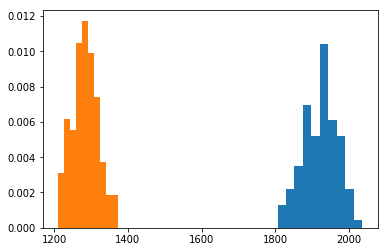

In [313]:
L=2000
mu=6E-4
mutations = []
p_scores = []
for i in range(100):
    mutations.append(jc_muts(true_tree, L, mu)[1]) # get true number of mutations in a tree
    p_scores.append(fitch(true_tree)) # get parsimony score for a tree

plt.hist(mutations, bins = 10, density = True) # plot overlayed histograms of scores/mutations
plt.hist(p_scores, bins = 10, density = True)

### iv. Report (1 points)

Briefly explain what happened during your experiment and why.

Tip: try different mutation rates $\mu$ to your method in iii.

In blue we observe the number of mutations during each simulation and in orange we observe the parsimony score of the given tree. For very high mutation rates the distributions get further away from each other as there is a loss of information on bases that mutate multiple times when calculating the parsimony score, this information isn't lost when counting the mutations. On low mutation rates we see the two distributions start to converge towards each other, this is because there is little information loss when calculating the parsimony score compared to the actual number of mutations.